In [2]:
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
from imageio import imread
import morphsnakes as ms
from tqdm import tqdm

In [3]:
uuid_scale={}
scale_root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/scale_annotations.xml').getroot()
for image in scale_root.findall('image'):
    uuid = image.attrib['name'][:-4]
    for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            scale = arr[1][1]-arr[0][1]
            uuid_scale[uuid]=scale       

base_dir = '/mnt/process/data_first/cervix_image_with_mask_and_bbox/images'
root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/annotations.xml').getroot()
name_df = pd.read_csv('/mnt/process/data_first/uuid_name.csv',index_col=0)
info_df = pd.read_csv('/mnt/process/data_first/yunzhou.csv',index_col=0)


cervixs=[]
labels=[]
names=[]
uuids=[]
polygons=[]
boxes=[]
img_paths=[]
scales=[]
masks = []

for image in root.findall('image'):
    flag=True
    path = image.attrib['name']
    img_path = os.path.join(base_dir, path)   
    uuid = path.split('/')[-1][:-4]  
    for anno in image:
        if anno.tag == 'box':
            xtl = round(float(anno.attrib['xtl']))
            ytl = round(float(anno.attrib['ytl']))
            xbr = round(float(anno.attrib['xbr']))
            ybr = round(float(anno.attrib['ybr']))
            box=np.array([xtl,ytl,xbr,ybr])
           
        elif anno.tag == 'polygon':
            polygon = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            mask =  np.around(polygon).astype(np.int32)

    try:
        name = name_df.loc[uuid]['Source'] 
        name = name.split('/')[-1].split('_')[0]
    except:
        # print('Person not found')
        flag=False

    try:
        label = info_df.loc[name]['自发性早产诊断']
        # print(label)
    except:
        # print('Label not found')
        flag=False

    try:
        cervix = info_df.loc[name]['孕中期宫颈长度']
        if np.isnan(cervix):
           flag = False
        #    print(name)
    except:
        # print('Cervix not found')
        flag=False
    
    scale = uuid_scale[uuid]
    
    if flag:
        cervixs.append(cervix)
        labels.append(label)
        names.append(name)
        uuids.append(uuid)
        polygons.append(polygon)
        boxes.append(box)
        img_paths.append(img_path)
        scales.append(scale)
        masks.append(mask)
        


    

print(len(labels))
print(len(cervixs))
print(len(scales))

275
275
275


In [28]:
distributions = []
for img_path,mask,label,scale,name in zip(img_paths,masks,labels,scales,names):
    distribution = []
    img= cv2.imread(img_path)
    the_mask = np.zeros(img.shape[:-1], dtype=np.float32)
    cv2.fillPoly(the_mask, [mask], color=1)
    img = img[...,0]
    area = np.sum((the_mask!=0))
    for i in range(0,255,5):
        part_area = np.sum((the_mask!=0) * (img >= i) * (img < i+5))
        part_area = part_area/area
        distribution.append(part_area)
    distributions.append(distribution)

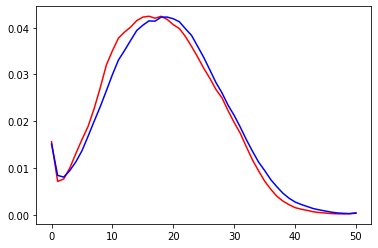

In [29]:
healthy_distribution = np.zeros(len(distributions[0]))
zaochan_distribution = np.zeros(len(distributions[0]))
hcnt = 0
zcnt =0
for label,distribution in zip(labels,distributions):
    if label ==0 :
        healthy_distribution += np.array(distribution)
        hcnt += 1
    else:
        zaochan_distribution += np.array(distribution)
        zcnt += 1
healthy_distribution/=hcnt
zaochan_distribution/=zcnt
plt.plot(zaochan_distribution,color='r')
plt.plot(healthy_distribution,color='b')

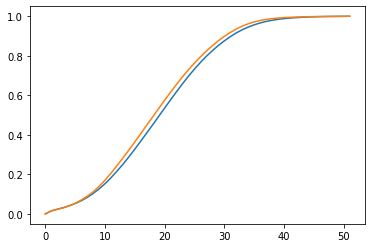

In [30]:
zaochan_cdf = [0]
healthy_cdf = [0]
zsum = 0
hsum = 0
for h,z in zip(healthy_distribution,zaochan_distribution):
    hsum += h
    zsum += z
    healthy_cdf.append(hsum)
    zaochan_cdf.append(zsum)

plt.plot(healthy_cdf)
plt.plot(zaochan_cdf)

In [18]:
np.array(distributions)[...,20:22].shape

(275, 2)

Train:
0.5113901250264886


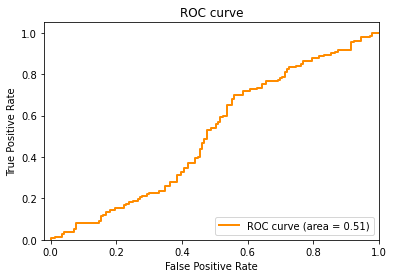

In [34]:

#回归


# x = np.array(np.array(distributions)[...,20],dtype=np.float32)
y = np.array(labels,dtype=np.float32)
# x = np.reshape(x,(-1,1))
x = []
for i in range(len(labels)):
    x.append([sum(distributions[i][15:20])])

def print_result(y_pred,y_test):
    fpr, tpr, _ = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
   
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc
    


def train_and_test(need_test):
    if need_test:
        seed = random.randint(0,1000000)
        test_size=0.2
      
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,random_state=seed,stratify=y)
    else:
        x_train,y_train = x,y


    model= LogisticRegression()
    model.fit(x_train,y_train)
    train_pred=model.predict_proba(x_train)[:,1]
    print("Train:")
    print_result(train_pred,y_train)
    if need_test:
        y_pred=model.predict_proba(x_test)[:,1]     
        print("Test:")
        print_result(y_pred,y_test)

train_and_test(False)

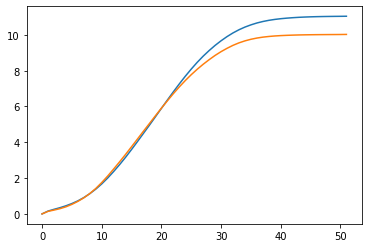

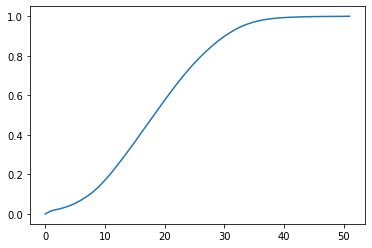